## <h1><center>This is my attempt  to solve the Titanic Challenge on Kaggle</center><h1>
<h1><center><a href=https://www.kaggle.com/competitions/titanic>Click here to see the challenge</a></center></h1>

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/RMS_Titanic_3.jpg/979px-RMS_Titanic_3.jpg")

## Importing the necessary libraries

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder

In [3]:
sns.set_theme('notebook', style='dark')
plt.style.use("dark_background")

# <ins>Reading the data</ins>

In [4]:
pd.set_option('mode.chained_assignment', None)
train_data=pd.read_csv("https://raw.githubusercontent.com/ArisPagonopoulos/Titanic-Challenge-Kaggle/main/train.csv",usecols=["Survived","Pclass","Name","Sex","Age","SibSp","Parch","Fare","Embarked","Ticket","Cabin"])
test_data=pd.read_csv("https://raw.githubusercontent.com/ArisPagonopoulos/Titanic-Challenge-Kaggle/main/test.csv",sep=",",usecols=["PassengerId","Pclass","Name","Sex","Age","SibSp","Parch","Fare","Embarked","Ticket","Cabin"])

In [5]:
np.sum(train_data.isna())

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [6]:
train_data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## We have many NA values in Age and Cabin columns, as we can see visually below

[]

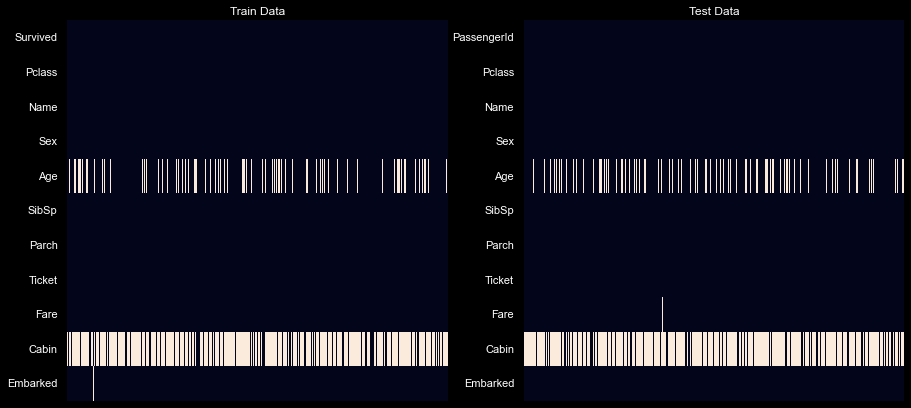

In [7]:
f,ax=plt.subplots(1,2,figsize=(15,7))
sns.heatmap(train_data.isna().transpose(),cbar=False,ax=ax[0])
ax[0].set_title("Train Data")
ax[0].set_xticks([])
sns.heatmap(test_data.isna().transpose(),cbar=False,ax=ax[1])
ax[1].set_title("Test Data")
ax[1].set_xticks([])

### We fill the fare missing in test data

In [8]:
np.sum(test_data.isna())
test_data["Fare"]=test_data["Fare"].fillna(test_data["Fare"].mean())

### Let's drop the Cabin value since it has so many na values

In [9]:
train_data.drop("Cabin",axis=1,inplace=True)
test_data.drop("Cabin",axis=1,inplace=True)

### We fill the missing embarked values based on mean fare per public class

In [10]:
train_data.groupby(["Pclass","Embarked"]).Fare.mean()
train_data[train_data.Embarked.isna()]
train_data.Embarked.fillna("C",inplace=True)

## Before filling the missing Age values, we need to apply some feature extraction from the Name column

### Let's extract the title of each passenger

In [11]:
if np.sum(train_data.Name.isna())!=0:
    print("They are some nan values")
    

def titles(s):
    res=re.search("(\w+)\.",s)
    if res:
        return res.group(0)
    return s

train_data.Name = train_data.Name.apply(titles)
test_data.Name=test_data.Name.apply(titles)
train_data.Name.value_counts()

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Mlle.          2
Major.         2
Col.           2
Countess.      1
Capt.          1
Ms.            1
Sir.           1
Lady.          1
Mme.           1
Don.           1
Jonkheer.      1
Name: Name, dtype: int64

### ...and replace each title with a numeric value

In [12]:
train_data["Name"]=train_data["Name"].replace("Ms.","Miss.")
train_data["Name"]=train_data["Name"].replace("Mme.","Mr.")
train_data["Name"]=train_data["Name"].replace("Mlle.","Miss.")
train_data["Name"]=train_data["Name"].replace(["Don.","Jonkheer.","Countess.","Sir.","Lady.","Don.","Major."],"noble")
train_data["Name"]=train_data["Name"].replace(["Col.","Rev.","Dr.","Capt."],"rare")
test_data["Name"]=test_data["Name"].replace("Ms.","Miss.")
test_data["Name"]=test_data["Name"].replace("Mme.","Mr.")
test_data["Name"]=test_data["Name"].replace("Mlle.","Miss.")
test_data["Name"]=test_data["Name"].replace(["Don.","Jonkheer.","Countess.","Sir.","Lady.","Don.","Dona.","Major."],"noble")
test_data["Name"]=test_data["Name"].replace(["Col.","Rev.","Dr.","Capt."],"rare")
l=list(train_data.Name.value_counts().index)
l2=list(test_data.Name.value_counts().index)
train_data.Name = train_data.Name.apply(lambda x:l.index(x))
test_data.Name=test_data.Name.apply(lambda x:l2.index(x))

### Now we can replace each missing Age value, with the mean based on it's Name and Sex value

In [13]:
df=train_data.iloc[:,:-1].append(test_data.iloc[:,:-1])
df["Age"].fillna(df.groupby(["Sex","Name"])["Age"].transform("mean"),inplace=True)
train_data["Age"]=df["Age"][:891]
test_data["Age"]=df["Age"][891:]

In [14]:
print(f"Number of missing values in train_data {np.sum(np.sum(train_data.isna()))}")
print(f"Numbero of missing values in test_data {np.sum(np.sum(test_data.isna()))}")

Number of missing values in train_data 0
Numbero of missing values in test_data 0


### Replacing the embarked with dummy values

In [15]:
fg=lambda x: 0 if x=="S" else (1 if x=="C" else 2)
train_data.loc[:,"Embarked"]=train_data.loc[:,"Embarked"].apply(fg)
test_data.loc[:,"Embarked"]=test_data.loc[:,"Embarked"].apply(fg)

### ... same for Sex and Ticket column

In [16]:
train_data.Sex=train_data.Sex.apply(lambda x:1 if x=="male" else 0)
test_data.Sex=test_data.Sex.apply(lambda x:1 if x=="male" else 0)

In [17]:
train_data["Ticket"]=train_data["Ticket"].str[:3]
test_data["Ticket"]=test_data["Ticket"].str[:3]
tg=lambda x:1 if x.isnumeric() else 0
train_data["Ticket"]=train_data["Ticket"].apply(tg)
test_data["Ticket"]=test_data["Ticket"].apply(tg)

### We create a new column: family size

In [18]:
p=train_data["Parch"]+train_data["SibSp"]+1
train_data["SizeofFamily"]=p
q=test_data["Parch"]+test_data["SibSp"]+1
test_data["SizeofFamily"]=q

### We create a new column IsAlone (with 1 if the passenger was alone in the trip and 0 if not)

In [19]:
alone=np.where(train_data.SibSp+train_data.Parch==0,1,0)
train_data["Alone"]=alone
alone2=np.where(test_data.SibSp+test_data.Parch==0,1,0)
test_data["Alone"]=alone2

### We create a new column Factor by multiplying the Pclass with the Age (we normalize the Age first)

In [20]:
train_data["Factor"]=((train_data["Pclass"]-train_data["Pclass"].mean())/(train_data["Pclass"].std()))*((train_data["Age"]-train_data["Age"].mean())/(train_data["Age"].std()))
test_data["Factor"]=((test_data["Pclass"]-test_data["Pclass"].mean())/(test_data["Pclass"].std()))*((test_data["Age"]-test_data["Age"].mean())/(test_data["Age"].std()))

### We split Age column in categories

In [21]:
r=pd.qcut(train_data.Age[train_data.Age.notna()],6).value_counts().index.categories
g=lambda y:list(map(lambda x:y in x,list(r))).index(True)
gg=lambda y:list(map(lambda x:y in x,list(rr))).index(True)
rr=pd.qcut(test_data.Age[test_data.Age.notna()],6).value_counts().index.categories
train_data["Age_Cat"]=train_data.Age[train_data.Age.notna()].apply(g)
test_data["Age_Cat"]=test_data.Age[test_data.Age.notna()].apply(gg)

### Same with the Fare

In [22]:
qq=pd.qcut(train_data["Fare"],4).value_counts().index.categories
ff=lambda y:list(map(lambda x:round(y,3) in x,list(qq))).index(True)
train_data["Fare_Cat"]=train_data["Fare"].apply(ff).astype(int)
qqq=pd.qcut(test_data["Fare"],4).value_counts().index.categories
fff=lambda y:list(map(lambda x:round(y,3) in x,list(qqq))).index(True)
test_data["Fare_Cat"]=test_data["Fare"].apply(fff).astype(int)

### Create a column  IsWomenOrChild(boolean)

In [23]:
train_data["IsWomanOrChild"]=pd.Series(np.zeros(train_data.shape[0],dtype=int))
train_data.IsWomanOrChild[(train_data.Sex==0) | (train_data.Age<=15)]=1
test_data["IsWomanOrChild"]=pd.Series(np.zeros(test_data.shape[0]))
test_data.IsWomanOrChild[(test_data.Sex==0) | (test_data.Age<=15)]=1

In [24]:
vis_df=train_data.copy()

### Apply OneHotEncoding to Embarked

In [25]:
def onehot(df,c,labels):
    encoder=OneHotEncoder(handle_unknown="ignore")
    encoder_df=pd.DataFrame(encoder.fit_transform(df[[c]]).toarray())
    columns=list(df.columns)
    df=df.join(encoder_df)
    df.columns=columns+labels
    df.iloc[:,-len(labels):]=df.iloc[:,-len(labels):].astype(int)
    df.drop(c,axis=1,inplace=True)
    return df
train_data=onehot(train_data,"Embarked",["Embarked{}".format(i) for i in ["S","C","Q"]])
test_data=onehot(test_data,"Embarked",["Embarked{}".format(i) for i in ["S","C","Q"]])

## Now let's see our data

In [26]:
train_data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,SizeofFamily,Alone,Factor,Age_Cat,Fare_Cat,IsWomanOrChild,EmbarkedS,EmbarkedC,EmbarkedQ
0,0,3,0,1,22.000000,1,0,0,7.2500,2,0,-0.483833,1,0,0,1,0,0
1,1,1,2,0,38.000000,1,0,0,71.2833,2,0,-0.969907,4,3,1,0,1,0
2,1,3,1,0,26.000000,0,0,0,7.9250,1,1,-0.234774,2,1,1,1,0,0
3,1,1,2,0,35.000000,1,0,1,53.1000,2,0,-0.616332,4,3,1,1,0,0
4,0,3,0,1,35.000000,0,0,1,8.0500,1,1,0.325609,4,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,4,1,27.000000,0,0,1,13.0000,1,1,0.077013,2,1,0,1,0,0
887,1,1,1,0,19.000000,0,0,1,30.0000,1,1,1.269401,0,2,1,1,0,0
888,0,3,1,0,21.824366,1,2,0,23.4500,4,0,-0.494769,1,2,1,1,0,0
889,1,1,0,1,26.000000,0,0,1,30.0000,1,1,0.444393,2,2,0,0,1,0


# <ins>Exploratory Data Analysis</ins>

## What's the proportion of people who survived?

Text(0.5, 1.0, 'Survival')

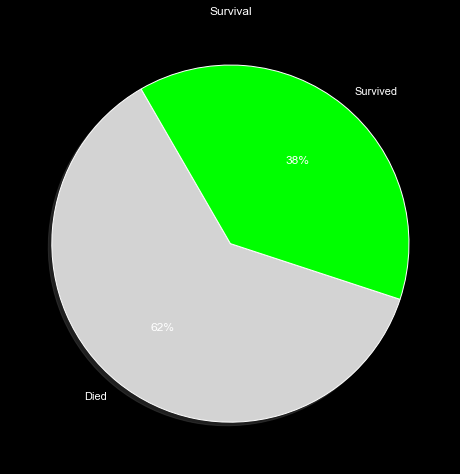

In [27]:
plt.figure(figsize=(8,15))
plt.pie(train_data.Survived.value_counts(),labels=["Died","Survived"],colors=["lightgrey","lime"],shadow=True,autopct='%.0f%%',startangle=120)
plt.title("Survival")

## Passengers in higher class had a better chance of surviving

In [28]:
train_data.groupby("Pclass",as_index=False)["Survived"].mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

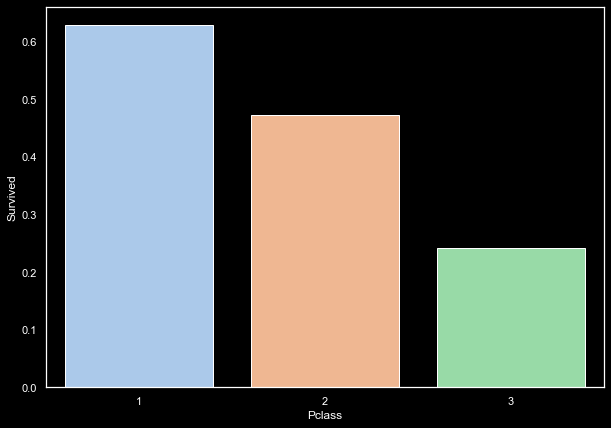

In [29]:
plt.figure(figsize=(10,7))
sns.barplot(x="Pclass",y="Survived",data=train_data.groupby("Pclass",as_index=False)["Survived"].mean(),palette="pastel")

### Embarkation points have a correlation with survival

In [30]:
vis_df.groupby("Embarked",as_index=False)["Survived"].mean()

,Embarked,Survived
0,0,0.336957
1,1,0.558824
2,2,0.389610


In [31]:
surv_emb=vis_df.groupby("Embarked",as_index=False)["Survived"].mean()

In [32]:
surv_emb["Died"]=1-surv_emb["Survived"]
pv=pd.pivot_table(surv_emb,index="Embarked",values=["Survived","Died"])

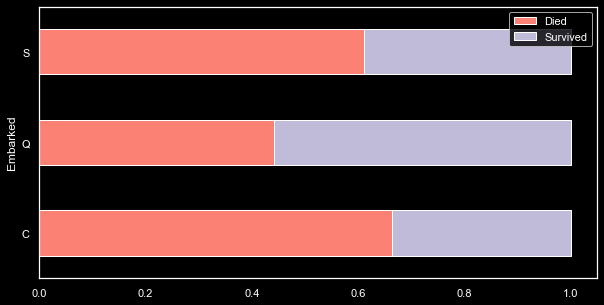

In [33]:
pv.plot(kind="barh",stacked=True,figsize=(10,5),color=["C3","C2"])
loc,labels=plt.yticks()
_=plt.yticks(loc,labels=["C","Q","S"])

## It appears that ticket has no correlation with survival

In [34]:
train_data.groupby("Ticket")["Survived"].mean()

Ticket
0    0.382609
1    0.384266
Name: Survived, dtype: float64

## Most women survived in titanic disaster

In [35]:
train_data.groupby("Sex")["Survived"].mean()

Sex
0    0.742038
1    0.188908
Name: Survived, dtype: float64

<Figure size 1080x648 with 0 Axes>

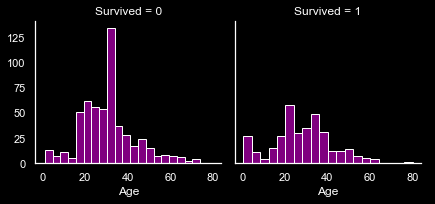

In [36]:
plt.figure(figsize=(15,9))
g = sns.FacetGrid(train_data, col='Survived')
g.map(plt.hist, 'Age', bins=20,color="purple")
g.add_legend()

## Men were more likely to survive if they were younger, the oposite is true for the women
## (female=0,male=1)

In [37]:
train_data.groupby(["Sex","Survived"])["Age"].mean()

Sex  Survived
0    0           24.932389
     1           28.674050
1    0           31.679137
     1           27.515279
Name: Age, dtype: float64

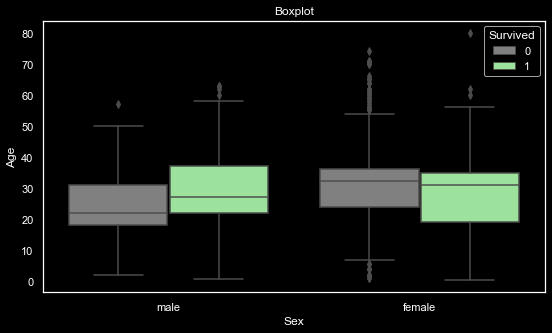

In [38]:
plt.figure(figsize=(9,5))
sns.boxplot(x="Sex",y="Age",hue="Survived",data=train_data,palette=["gray","lightgreen"])
plt.title("Boxplot")
loc,labels=plt.xticks()
_=plt.xticks(loc,["male","female"])

C:\Users\aris\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 13.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


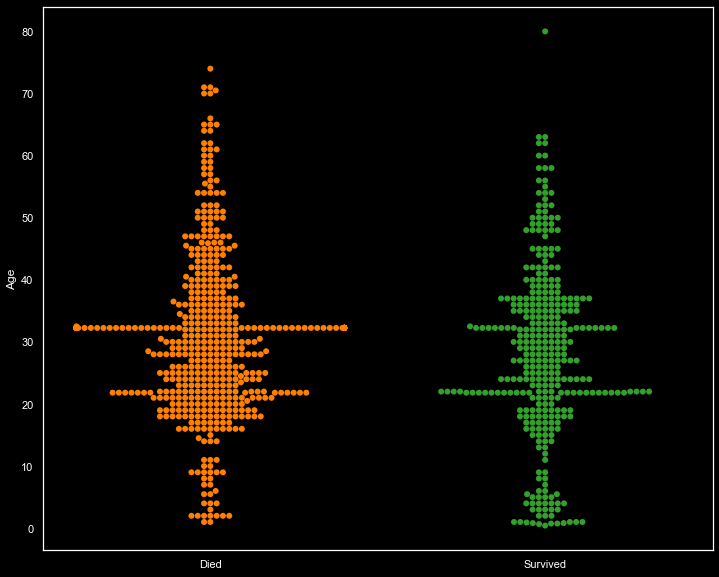

In [39]:
f=plt.figure(figsize=(12,10))
ax=f.gca()
sns.swarmplot(x="Survived",y="Age",data=train_data,palette="Paired_r",ax=ax,s=6)
loc,labels=plt.xticks()
plt.xlabel("")
new_labels=["Died","Survived"]
_=plt.xticks(loc,new_labels)

## Women, children and nobles were more likely to survive

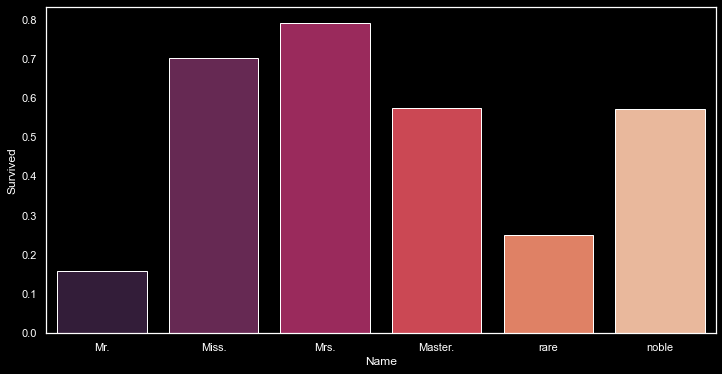

In [40]:
plt.figure(figsize=(12,6))
a=train_data.groupby("Name",as_index=False)["Survived"].mean()
t=pd.pivot_table(data=a,index=pd.Index(l),values="Survived")
_=sns.barplot(x="Name",y="Survived",data=a,palette="rocket",edgecolor="white")
__=_.set_xticks(range(len(l)),labels=l)

In [41]:
train_data.groupby("Survived")["Fare"].mean()

Survived
0    22.117887
1    48.395408
Name: Fare, dtype: float64

### People who survived belonged to higher fare category

([<matplotlib.axis.XTick at 0x26a18785a88>,
 [Text(0, 0, 'Died'), Text(1, 0, 'Survived')])

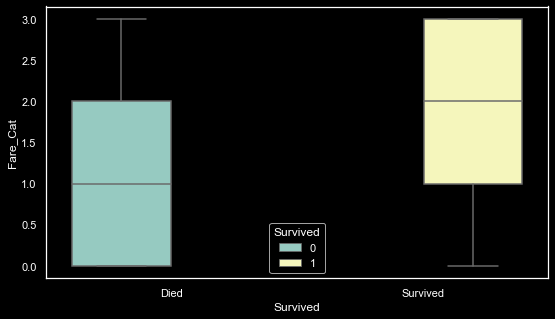

In [42]:
plt.figure(figsize=(9,5))
_=sns.boxplot(x="Survived",y="Fare_Cat",hue="Survived",data=train_data)
loc,labels=plt.xticks()
plt.xticks(loc,labels=["Died","Survived"])

### Dropping the columns that we will not need

In [43]:
train_data.drop(["Age","Ticket","Fare_Cat"],axis=1,inplace=True)
test_data.drop(["Age","Ticket","Fare_Cat",],axis=1,inplace=True)
ids=test_data.pop("PassengerId")
train_data_target=train_data.pop("Survived")

## Normalizing the Data

In [44]:
scaler=StandardScaler()
scaler.fit(train_data)
train_data_scaled=scaler.transform(train_data)
test_data_scaled=scaler.transform(test_data)

# <ins>Testing some models</ins>

In [45]:
clf = GaussianNB()
scores = cross_val_score(clf, train_data_scaled,train_data_target, cv=7)
clf.fit(train_data_scaled,train_data_target)
result_clf=clf.predict(test_data_scaled)
scores.mean(),scores.std()

(0.8036153683914511, 0.02161495815673101)

In [46]:
from sklearn.model_selection import cross_val_score
clf=SVC(C=1,gamma=0.2,kernel="rbf")
scores=cross_val_score(clf,train_data_scaled,train_data_target,cv=7)
clf.fit(train_data_scaled,train_data_target)
scores.mean(),scores.std()

(0.820470683352081, 0.03454553680162272)

In [47]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(max_features="auto",min_samples_leaf=1,min_samples_split=7)
score=cross_val_score(decision_tree,train_data_scaled,train_data_target)
decision_tree.fit(train_data_scaled,train_data_target)
score.mean(),score.std()

(0.7901512773837173, 0.027646544540279788)

In [48]:
from sklearn.ensemble import RandomForestClassifier
forest=RandomForestClassifier(criterion="gini",min_samples_split=4,n_estimators=200,n_jobs=-1)
scores=cross_val_score(forest,train_data_scaled,train_data_target,cv=7)
forest.fit(train_data_scaled,train_data_target)
forest.fit(train_data_scaled,train_data_target)
scores.mean(),scores.std()

(0.8182121766029246, 0.02134292347597264)

<AxesSubplot:xlabel='Feature_Importance'>

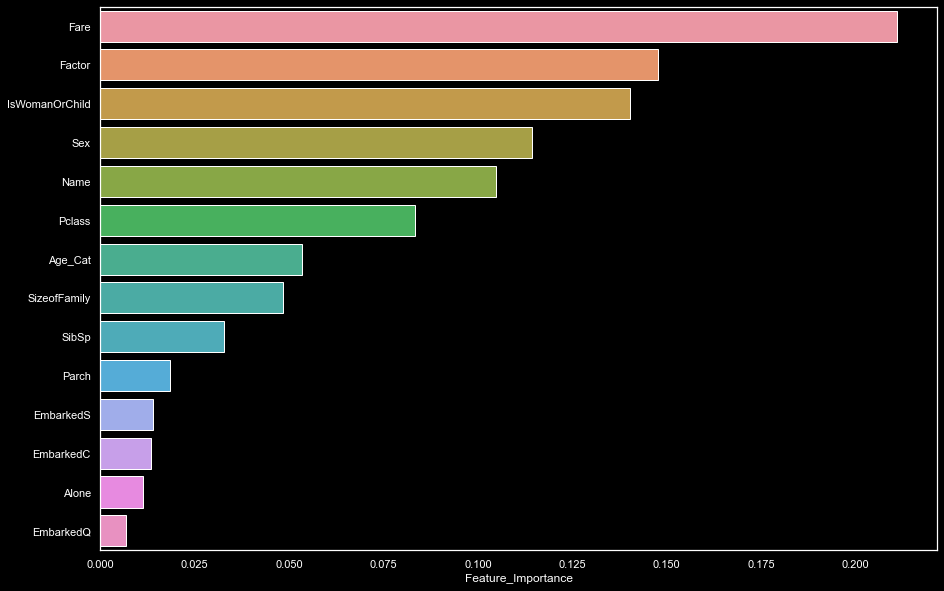

In [49]:
importances_df=pd.DataFrame(forest.feature_importances_,columns=["Feature_Importance"],index=train_data.columns)
importances_df.sort_values(by=["Feature_Importance"],inplace=True,ascending=False)
f=plt.figure(figsize=(15,10))
ax=f.gca()
sns.barplot(y=importances_df.index,x=importances_df.Feature_Importance,orient="h",ax=ax)

# SVC is the best model (score in kaggle 0.78468)